# TP - Sentiment Analysis (With Word2Vec)

- Data augmentation
- Use of Word2Vec
- Pycaret models
- Added Neural networks (MLP Classifier)
- Tested tuning, bagging, boosting, blend,...
- Save best model with Word2Vec

**Final experiment with pycaret: from this we obtain the last and final model with Word2Vec**




## Data Augmentation

- Execute before install pycaret!

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# "Mount" do Google Drive

drive.mount('/content/drive')
initial_df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis_exp2.csv')

initial_df

Mounted at /content/drive


Phrase    Target
0     always experience gf gone first like oh cool m...   Neutral
1     right people maybe wont kill feel isolated lon...  Negative
2              know youre lonely come promise take care  Positive
3                            give boost lonely she28ric  Positive
4                                    getting lonely top  Negative
...                                                 ...       ...
2502  certainly another radar see lonely eyes follow...   Neutral
2503  69 girls always grow overnight meeting people ...   Neutral
2504  beauty power antiphons come come emmanuel rans...   Neutral
2505                                rianbow gang hereee   Neutral
2506  article really nails right wing media people k...   Neutral

[2507 rows x 2 columns]

In [ ]:
# Pre-processing steps to fix target 

for i, value in enumerate(initial_df['Target']):
  initial_df['Target'][i] = value.strip()
  if value == 'Nuetral':
    initial_df['Target'][i] = 'Neutral'

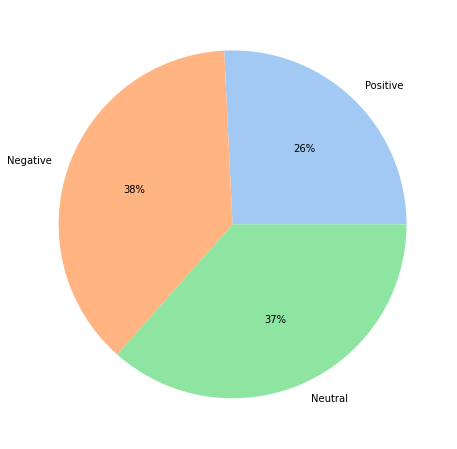

In [ ]:
# Class distribution

countPositives = initial_df[initial_df.Target == 'Positive'].Target.count()
countNegatives = initial_df[initial_df.Target == 'Negative'].Target.count()
countNeutral = initial_df[initial_df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

**From this data we will separate an external validation set and we will only augment the train/test set!**

In [ ]:
df = initial_df.sample(frac=0.95, random_state=786)
data_unseen = initial_df.drop(df.index)

print('Data for Modeling: ' + str(df.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (2382, 2)
Unseen Data For Predictions (125, 2)


**We need to augment dataset in a way that will have all three classes balanced**

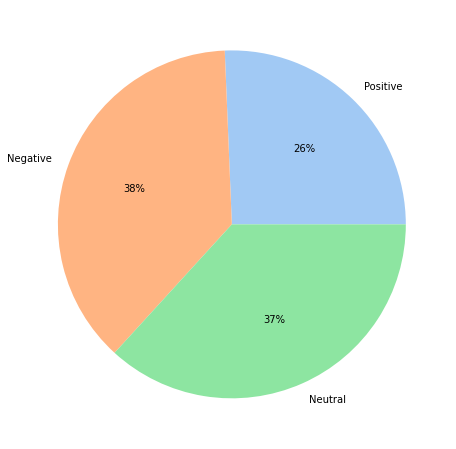

In [ ]:
# Class distribution (after validation set created)

countPositives = df[df.Target == 'Positive'].Target.count()
countNegatives = df[df.Target == 'Negative'].Target.count()
countNeutral = df[df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
# Count for each class
# We need about 260 positive instances to balance dataset

df['Target'].value_counts()

Negative    895
Neutral     876
Positive    611
Name: Target, dtype: int64

In [ ]:
!pip install numpy requests nlpaug

In [ ]:
!pip install nltk>=3.4.5

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
#Synonyms augmenter - it will create new phrases generate phrases with the same meaning but other words (synonyms)

aug = naw.SynonymAug(aug_src='wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Balance Dataset

pos_df = df.loc[df['Target'] == 'Positive']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n != 260:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


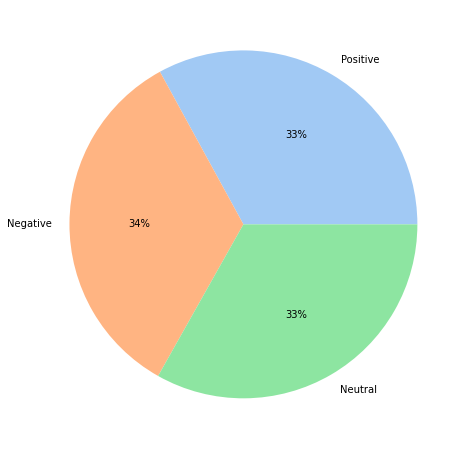

In [ ]:
# Class distribution (after balance with augmentation)

countPositives = df[df.Target == 'Positive'].Target.count()
countNegatives = df[df.Target == 'Negative'].Target.count()
countNeutral = df[df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
df['Target'].value_counts()

Negative    895
Neutral     876
Positive    871
Name: Target, dtype: int64

**Now we need more data so we will try to almost duplicate the classes instances using augmentation**

- 800 new instances for every class to maintain balance

In [ ]:
# Positive class augmentation

pos_df = df.loc[df['Target'] == 'Positive']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n != 800:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

In [ ]:
# Negative class augmentation

pos_df = df.loc[df['Target'] == 'Negative']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n != 800:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

In [ ]:
# Neutral class augmentation

pos_df = df.loc[df['Target'] == 'Neutral']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n !=800:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

**Check the final dataset distribution and class instances**

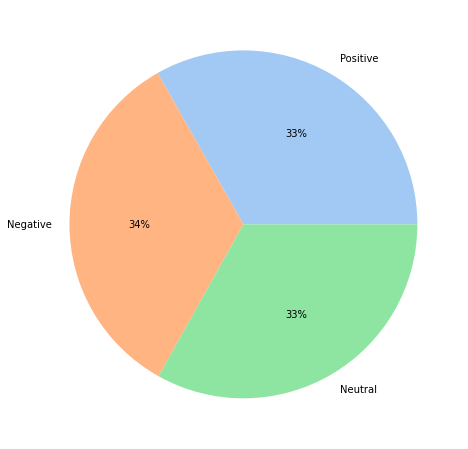

In [ ]:
## Class distribution (final augmented dataset)

countPositives = df[df.Target == 'Positive'].Target.count()
countNegatives = df[df.Target == 'Negative'].Target.count()
countNeutral = df[df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
df['Target'].value_counts()

Negative    1695
Positive    1671
Neutral     1666
Name: Target, dtype: int64

In [ ]:
# 5032 instances

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Phrase  5032 non-null   object
 1   Target  5032 non-null   object
dtypes: object(2)
memory usage: 78.8+ KB


In [ ]:
# save both validation and train/test set

df.to_csv('FinalTrainTest.csv',index=False)
data_unseen.to_csv('FinalValSet.csv',index=False)

## Pycaret install and config

In [ ]:
!python --version

Python 3.8.16


In [ ]:
!pip install pycaret

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pycaret.utils import enable_colab
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
enable_colab()

Colab mode enabled.


In [ ]:
df = pd.read_csv('/content/FinalTrainTest.csv')
unseen_data = pd.read_csv('/content/FinalValSet.csv')

In [ ]:
#Join data to apply Word2Vec below
all_df = df.append(unseen_data, ignore_index=True)

In [ ]:
unseen_data

Phrase    Target
0    disappear one day lonely sad students right ab...  Negative
1                             sorry text lot im lonely  Negative
2    lonely yes yes oh god yes trying imagine world...  Positive
3    lonely girl high paying job ceo smith amp sons...  Positive
4    sora ah thank goodness found sorry left lonely...  Positive
..                                                 ...       ...
120  absolutely frustrated went astral finding seei...   Neutral
121  start prescribing spoonfuls nutella instead an...   Neutral
122  rapid acting antidepressants volume 89 advance...   Neutral
123                   antidepressants even makes gravy   Neutral
124                       5 reasons feel relationships   Neutral

[125 rows x 2 columns]

In [ ]:
all_df

Phrase    Target
0     lonely best way focus become stronger man let ...  Positive
1                                    call keith mystery   Neutral
2     long road lonely one still find answers im cho...   Neutral
3     ship chaos escape futile emergency repair resu...  Negative
4                       ladies lonely come keep company   Neutral
...                                                 ...       ...
5152  absolutely frustrated went astral finding seei...   Neutral
5153  start prescribing spoonfuls nutella instead an...   Neutral
5154  rapid acting antidepressants volume 89 advance...   Neutral
5155                   antidepressants even makes gravy   Neutral
5156                       5 reasons feel relationships   Neutral

[5157 rows x 2 columns]

## Word2Vec

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.sklearn_api import W2VTransformer
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_df['Phrase'], all_df['Target'] , test_size=0.2)

In [ ]:
X_train

1003    point feel like u something better talk someon...
4218    hate way antidepressants make feel hate taking...
3197    took hand talk piffling shy lonely people situ...
1373                           definitely sure frustrated
3566                       lonely im mister lonely nobody
                              ...                        
3455    stay home girl hardworking man mixture bc 13 a...
5111                                 nonstop nut november
2516    in spades rattling time shared besides must pr...
3663                  average im depressed surprised down
2282    feeling sooo unlucky n hopeless life mental is...
Name: Phrase, Length: 4125, dtype: object

In [ ]:
sentences=[]
sum=0
for tweet in all_df['Phrase']:
    sents=word_tokenize(tweet)
    sum+=len(sents)
    sentences.append(sents) 

print(sum)
print(len(sentences))  

58162
5157


In [ ]:
w2v_model = Word2Vec(sentences=all_df['Phrase'],size=300,window=10,min_count=1)

In [ ]:
import gensim
print(gensim.__version__)

3.6.0


In [ ]:
!pip install --force-reinstall gensim==3.8.0

In [ ]:
words = set(w2v_model.wv.vocab.keys())
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in all_df['Phrase']])

In [ ]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

## TF-IDF

### Classification with PyCaret

In [ ]:
from pycaret.classification import *

In [ ]:
#list to dataframe 


df_train = pd.DataFrame (X_train_vect_avg, columns=['col_'+ str(i) for i in range(300)])

In [ ]:
df_train_y = pd.DataFrame (y_train.values.ravel())

In [ ]:
df_train_y

0
0      Neutral
1     Negative
2     Positive
3     Negative
4     Negative
...        ...
4120  Negative
4121   Neutral
4122  Positive
4123  Negative
4124  Negative

[4125 rows x 1 columns]

In [ ]:
df_train['Target'] = all_df['Target']

In [ ]:
df_train['Target']

0       Positive
1        Neutral
2        Neutral
3       Negative
4        Neutral
          ...   
5152     Neutral
5153     Neutral
5154     Neutral
5155     Neutral
5156     Neutral
Name: Target, Length: 5157, dtype: object

In [ ]:
df = df_train.loc[:'5031']
unseen_data = df_train.loc['5032':]

In [ ]:
# 70/30 - train and test split by default

exp_1 = setup(data=df, target='Target', remove_perfect_collinearity=False, numeric_features=df.drop(['Target'], axis=1).columns.tolist())

Description  \
0                               session_id   
1                                   Target   
2                              Target Type   
3                            Label Encoded   
4                            Original Data   
5                           Missing Values   
6                         Numeric Features   
7                     Categorical Features   
8                         Ordinal Features   
9                High Cardinality Features   
10                 High Cardinality Method   
11                   Transformed Train Set   
12                    Transformed Test Set   
13                      Shuffle Train-Test   
14                     Stratify Train-Test   
15                          Fold Generator   
16                             Fold Number   
17                                CPU Jobs   
18                                 Use GPU   
19                          Log Experiment   
20                         Experiment Name   
21                                     USI   
22                         Imputation Type   
23          Iterative Imputation Iteration   
24                         Numeric Imputer   
25      Iterative Imputation Numeric Model   
26                     Categorical Imputer   
27  Iterative Imputation Categorical Model   
28           Unknown Categoricals Handling   
29                               Normalize   
30                        Normalize Method   
31                          Transformation   
32                   Transformation Method   
33                                     PCA   
34                              PCA Method   
35                          PCA Components   
36                     Ignore Low Variance   
37                     Combine Rare Levels   
38                    Rare Level Threshold   
39                         Numeric Binning   
40                         Remove Outliers   
41                      Outliers Threshold   
42                Remove Multicollinearity   
43             Multicollinearity Threshold   
44             Remove Perfect Collinearity   
45                              Clustering   
46                    Clustering Iteration   
47                     Polynomial Features   
48                       Polynomial Degree   
49                    Trignometry Features   
50                    Polynomial Threshold   
51                          Group Features   
52                       Feature Selection   
53                Feature Selection Method   
54            Features Selection Threshold   
55                     Feature Interaction   
56                           Feature Ratio   
57                   Interaction Threshold   
58                           Fix Imbalance   
59                    Fix Imbalance Method   

                                   Value  
0                                   1537  
1                                 Target  
2                             Multiclass  
3   Negative: 0, Neutral: 1, Positive: 2  
4                            (5032, 301)  
5                                  False  
6                                    300  
7                                      0  
8                                  False  
9                                  False  
10                                  None  
11                           (3522, 300)  
12                           (1510, 300)  
13                                  True  
14                                 False  
15                       StratifiedKFold  
16                                    10  
17                                    -1  
18                                 False  
19                                 False  
20                      clf-default-name  
21                                  92b6  
22                                simple  
23                                  None  
24                                  mean  
25                                  None  
26                              constant  
27                  

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['col_0', 'col_1',
                                                          'col_2', 'col_3',
                                                          'col_4', 'col_5',
                                                          'col_6', 'col_7',
                                                          'col_8', 'col_9',
                                                          'col_10', 'col_11',
                                                          'col_12', 'col_13',
                                         

In [ ]:
top3 = compare_models(n_select = 3)

Model  Accuracy     AUC  Recall   Prec.  \
qda       Quadratic Discriminant Analysis    0.5460  0.7250  0.5463  0.5545   
et                 Extra Trees Classifier    0.5230  0.7028  0.5231  0.5263   
lightgbm  Light Gradient Boosting Machine    0.5193  0.7010  0.5197  0.5209   
rf               Random Forest Classifier    0.5131  0.6971  0.5133  0.5150   
gbc          Gradient Boosting Classifier    0.5131  0.6879  0.5137  0.5189   
lda          Linear Discriminant Analysis    0.4835  0.6699  0.4842  0.4835   
ada                  Ada Boost Classifier    0.4710  0.6482  0.4721  0.4765   
nb                            Naive Bayes    0.4594  0.6396  0.4614  0.4727   
knn                K Neighbors Classifier    0.4509  0.6323  0.4500  0.4562   
ridge                    Ridge Classifier    0.4492  0.0000  0.4491  0.4476   
lr                    Logistic Regression    0.4489  0.6311  0.4485  0.4473   
svm                   SVM - Linear Kernel    0.4336  0.0000  0.4337  0.4571   
dt               Decision Tree Classifier    0.4302  0.5724  0.4303  0.4315   
dummy                    Dummy Classifier    0.3407  0.5000  0.3333  0.1161   

              F1   Kappa     MCC  TT (Sec)  
qda       0.5425  0.3189  0.3231     0.185  
et        0.5228  0.2842  0.2852     1.103  
lightgbm  0.5189  0.2789  0.2796     9.420  
rf        0.5126  0.2694  0.2701     4.082  
gbc       0.5118  0.2697  0.2720    72.108  
lda       0.4824  0.2256  0.2261     0.252  
ada       0.4679  0.2070  0.2098     5.453  
nb        0.4452  0.1906  0.2010     0.044  
knn       0.4490  0.1750  0.1769     0.618  
ridge     0.4444  0.1734  0.1748     0.123  
lr        0.4434  0.1727  0.1744     0.814  
svm       0.3939  0.1502  0.1672     0.519  
dt        0.4296  0.1450  0.1454     1.136  
dummy     0.1732  0.0000  0.0000     0.027

INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1537, verbose=0,
                     warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0

In [ ]:
mlp_classifier = create_model('mlp')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.4476  0.6174  0.4473  0.4607  0.4438  0.1712  0.1752
1       0.5014  0.6795  0.5038  0.5104  0.4856  0.2539  0.2661
2       0.4403  0.6479  0.4420  0.4424  0.4343  0.1620  0.1645
3       0.4972  0.6677  0.4979  0.5086  0.4945  0.2459  0.2500
4       0.5057  0.6852  0.5076  0.5280  0.5007  0.2598  0.2697
5       0.5199  0.6889  0.5214  0.5349  0.5135  0.2807  0.2894
6       0.4886  0.6692  0.4894  0.5059  0.4851  0.2333  0.2391
7       0.4858  0.6595  0.4851  0.4948  0.4860  0.2274  0.2297
8       0.4943  0.6791  0.4962  0.5151  0.4861  0.2425  0.2530
9       0.5000  0.6784  0.5011  0.5128  0.4961  0.2504  0.2559
Mean    0.4881  0.6673  0.4892  0.5014  0.4826  0.2327  0.2393
Std     0.0238  0.0203  0.0242  0.0274  0.0234  0.0359  0.0381

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1537, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
INFO:logs:create_model() succesfully completed......................................


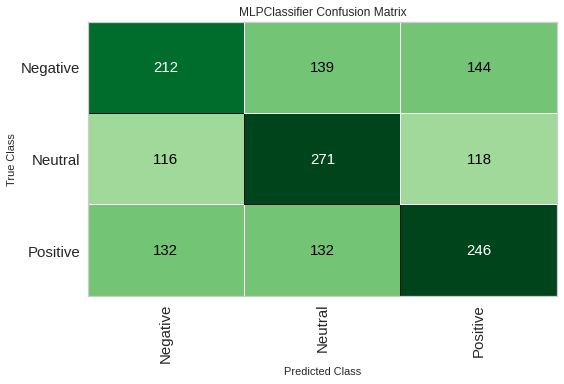

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(mlp_classifier, plot = 'confusion_matrix')

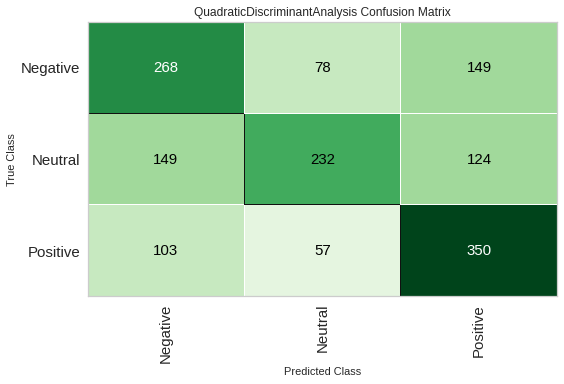

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[0], plot = 'confusion_matrix')

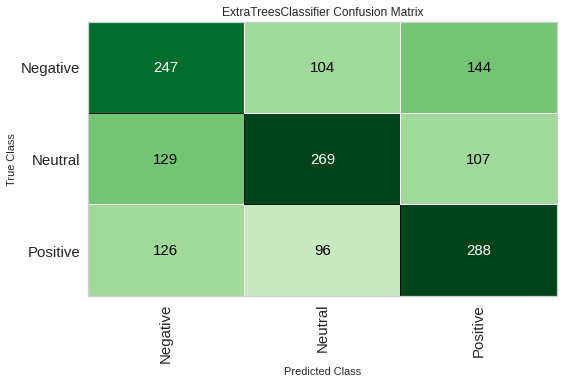

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[1], plot = 'confusion_matrix')

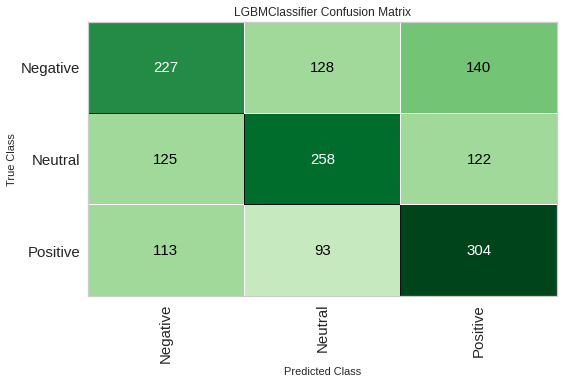

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[2], plot = 'confusion_matrix')

In [ ]:
predict_model(top3[0])

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Model  Accuracy     AUC  Recall   Prec.      F1  \
0  Quadratic Discriminant Analysis    0.5629  0.7274  0.5624  0.5701  0.5597   

    Kappa     MCC  
0  0.3442  0.3479

col_0     col_1     col_2     col_3     col_4     col_5     col_6  \
0    -0.036912 -0.012928 -0.050139 -0.002326 -0.051274  0.038526  0.006773   
1    -0.080170  0.021443 -0.094790 -0.043892 -0.072816  0.058777  0.028398   
2     0.042475 -0.042135  0.038113  0.056325  0.006623  0.004399 -0.087049   
3    -0.067788  0.011073 -0.082022 -0.037131 -0.070523  0.057608  0.029670   
4    -0.051929  0.011760 -0.062423 -0.023252 -0.051242  0.048215  0.002608   
...        ...       ...       ...       ...       ...       ...       ...   
1505 -0.089404  0.020892 -0.101544 -0.051273 -0.073537  0.054560  0.016026   
1506 -0.038143  0.012929 -0.035395 -0.005040 -0.031460  0.046961 -0.037333   
1507 -0.119620  0.049521 -0.121382 -0.076922 -0.075025  0.083059  0.022032   
1508 -0.051624 -0.026714 -0.077143 -0.008484 -0.081668  0.036941  0.045985   
1509 -0.044342  0.005653 -0.047842 -0.010856 -0.039952  0.042238 -0.020974   

         col_7     col_8     col_9  ...   col_293   col_294   col_295  \
0     0.003066 -0.006859  0.016708  ...  0.049025 -0.027958  0.023235   
1     0.035109 -0.025282  0.035138  ...  0.040916 -0.027517  0.011642   
2    -0.066957  0.052299 -0.012409  ...  0.089625 -0.031673  0.091050   
3     0.031639 -0.026283  0.030482  ...  0.041072 -0.030698 -0.001399   
4     0.013395 -0.009552  0.023811  ...  0.052132 -0.030610  0.029153   
...        ...       ...       ...  ...       ...       ...       ...   
1505  0.031931 -0.020165  0.036903  ...  0.045470 -0.022834  0.019367   
1506 -0.003022  0.012152  0.009891  ...  0.068999 -0.038832  0.051551   
1507  0.056137 -0.035572  0.034828  ...  0.041819 -0.023677  0.007777   
1508  0.006389 -0.030010  0.028215  ...  0.025951 -0.041440 -0.018896   
1509  0.007284  0.005534  0.017564  ...  0.064472 -0.022556  0.051500   

       col_296   col_297   col_298   col_299    Target     Label   Score  
0     0.030079  0.011227 -0.030427 -0.022178  Negative  Negative  1.0000  
1     0.033737  0.020967 -0.019256 -0.036057   Neutral  Positive  1.0000  
2     0.002032 -0.022608 -0.040496 -0.027793   Neutral  Negative  1.0000  
3     0.035858  0.026819 -0.016252 -0.032381  Negative  Positive  0.9803  
4     0.028870  0.009885 -0.022575 -0.032766  Negative  Positive  1.0000  
...        ...       ...       ...       ...       ...       ...     ...  
1505  0.023798  0.020140 -0.012429 -0.042819  Negative  Negative  1.0000  
1506  0.025947 -0.010607 -0.039872 -0.037720  Negative  Negative  1.0000  
1507  0.034276  0.017674 -0.018225 -0.047474   Neutral   Neutral  1.0000  
1508  0.037299  0.045574 -0.006501 -0.013092  Negative  Positive  1.0000  
1509  0.025107 -0.008892 -0.037252 -0.036875  Positive  Negative  1.0000  

[1510 rows x 303 columns]

## Save the best model

In [ ]:
# finalize model 

final_model = finalize_model(top3[0])

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=True, verbose=False, system=False, metrics=None, experiment_custom_tags=None, add_to_model_list=False, probability_threshold=None, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:

In [ ]:
result = predict_model(final_model, data = unseen_data)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Model  Accuracy     AUC  Recall  Prec.  F1  \
0  Quadratic Discriminant Analysis       0.0  0.6489       0      0   0   

   Kappa  MCC  
0      0    0

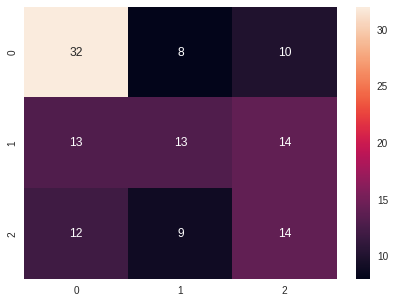

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(result['Target'], result['Label'])
plt.figure(figsize=(7, 5))
df_cm = pd.DataFrame(cm, range(3), range(3))
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 12}) # font size
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

accuracy_score(result['Target'], result['Label'])

0.472

In [ ]:
precision_score(result['Target'], result['Label'],average='macro')

0.4543859649122807

In [ ]:
recall_score(result['Target'], result['Label'],average='macro')

0.45500000000000007

In [ ]:
f1_score(result['Target'], result['Label'],average='macro')

0.45104035212856103

In [ ]:
cohen_kappa_score(result['Target'], result['Label'])

0.19472913616398246

In [ ]:
matthews_corrcoef(result['Target'], result['Label'])

0.19625942672195035

In [ ]:
save_model(final_model, 'final_model_word2vec')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), model_name=final_model_word2vec, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['col_0', 'col_1',
                                                          'col_2', 'col_3',
                                                          'col_4', 'col_5',
                                                          'col_6', 'col_7',
                                                          'col_8', 'col_9',
                                                          'col_10', 'col_11',


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['col_0', 'col_1',
                                                           'col_2', 'col_3',
                                                           'col_4', 'col_5',
                                                           'col_6', 'col_7',
                                                           'col_8', 'col_9',
                                                           'col_10', 'col_11',
                                                           'col_12', 'col_13',
                                                           'col_14', 'col_15',
                                                           'co